In [18]:

from hydra import initialize, initialize_config_module, initialize_config_dir, compose
from src.unit_proccessing import  *
from src.utils.stats_utils import *

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from pyod.models.thresholds import FILTER

In [19]:
with initialize(config_path='../configuration', version_base='1.1'):
    config = compose(config_name='main.yaml')

In [20]:
features_class = UnitDataProcessing(config)
self = features_class

IMPORTING: EPforR_TAP with version EPforR_TAP_16. 
EPforR_TAP with version EPforR_TAP_16 loaded. 
Paradata shape: (1894, 49) Questionnaires shape: (188, 37) Microdata shape: (754, 42) 
IMPORTING: EPforR_TAP with version EPforR_TAP_13. 
EPforR_TAP with version EPforR_TAP_13 loaded. 
Paradata shape: (1978, 49) Questionnaires shape: (188, 37) Microdata shape: (785, 42) 
IMPORTING: EPforR_TAP with version EPforR_TAP_11. 
EPforR_TAP with version EPforR_TAP_11 loaded. 
Paradata shape: (5573, 49) Questionnaires shape: (180, 37) Microdata shape: (2023, 42) 
IMPORTING: EPforR_TAP with version EPforR_TAP_19. 
EPforR_TAP with version EPforR_TAP_19 loaded. 
Paradata shape: (2007, 49) Questionnaires shape: (188, 37) Microdata shape: (832, 42) 
IMPORTING: EPforR_TAP with version EPforR_TAP_15. 
EPforR_TAP with version EPforR_TAP_15 loaded. 
Paradata shape: (2264, 49) Questionnaires shape: (188, 37) Microdata shape: (883, 42) 
IMPORTING: EPforR_TAP with version EPforR_TAP_10. 
EPforR_TAP with version

In [21]:
def custom_pause_duration_binning(seconds):
    if seconds < 3600*2:
        return round(seconds / 600) * 10
    elif 3600*2 <= seconds < 3600*5:
        return round(seconds / 1800) * 30
    elif 3600*5 <= seconds < 3600*24:  # 24 hours * 60 minutes/hour
        return round(seconds / 60) * 60
    else:
        return round(seconds / 1440) * 1440

In [64]:
df = self.get_df_time()
#df = self.df_unit
self = features_class
feature_name = 'f__pause_duration'
df = df[(~pd.isnull(df[feature_name]))].copy()
df[feature_name] = df[feature_name].astype(float)
#df[feature_name] = df[feature_name].apply(custom_pause_duration_binning).astype(float)
#.apply(transform_duartion)#/df_unit[~pd.isnull(df_unit[feature_name])]['f__number_answered']
#/df_unit[~pd.isnull(df_unit[feature_name])]['f__number_answered']

|## Plot the distribution of answer time set

<Axes: >

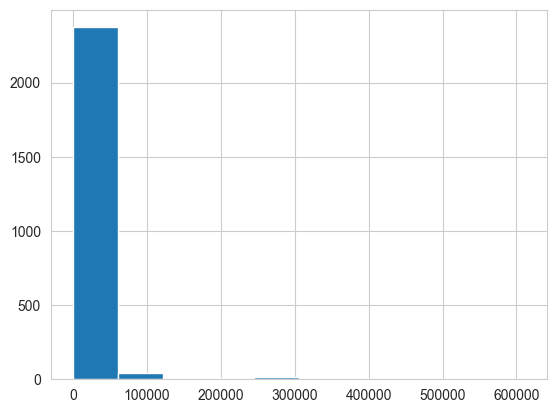

In [65]:
df[feature_name].hist()

<Axes: >

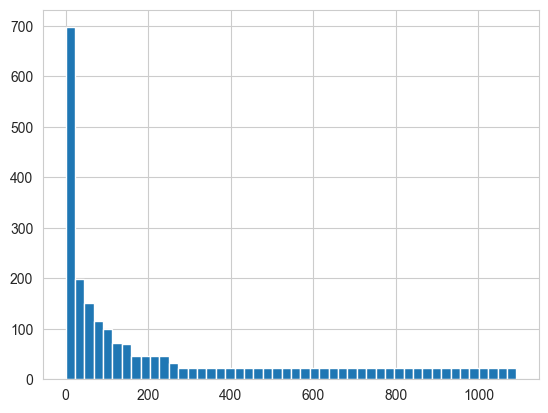

In [67]:
# Create a new column that has the hours mapped to order of frequency
sorted_pauses = df[feature_name].value_counts().index
hour_to_rank = {hour: rank for rank, hour in enumerate(sorted_pauses)}
# Sorting the DataFrame based on the 'frequency' column in descending order
df['frequency'] = df[feature_name].map(hour_to_rank)
df['frequency'].hist(bins=48)

## USE ECOD algorithm that makes use of cumulative function and is non-parametric for detecting anomalies in answer time set

In [68]:
model = ECOD(contamination=0.31)#FILTER( random_state=42))

model.fit(df[['frequency']])

ECOD(contamination=0.31, n_jobs=1)

In [69]:
df['anomaly'] = model.predict(df[['frequency']])

In [70]:
df['anomaly'].value_counts(), df['anomaly'].value_counts()/df['anomaly'].count()

(0    1682
 1     756
 Name: anomaly, dtype: int64,
 0    0.68991
 1    0.31009
 Name: anomaly, dtype: float64)

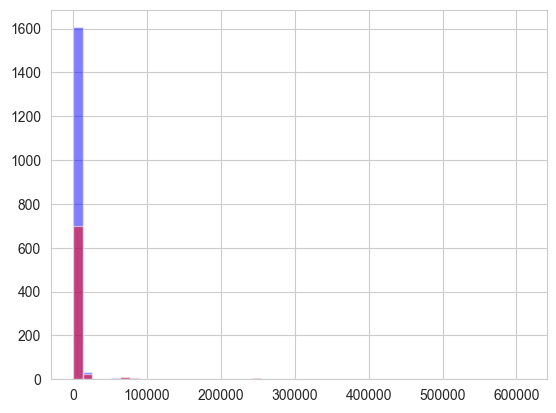

In [71]:
c=60*100000#48*5
data_true = df[(df['anomaly']==0)&(df[feature_name]<c)][feature_name]
data_false = df[(df['anomaly']==1)&(df[feature_name]<c)][feature_name]

# Determine the bin edges based on the entire dataset
bins = np.histogram_bin_edges(df[(df[feature_name]<c)][feature_name], bins=48)


plt.hist(data_true, bins=bins, alpha=0.5, color='blue', label='True')
plt.hist(data_false, bins=bins, alpha=0.5, color='red', label='False')
plt.show()

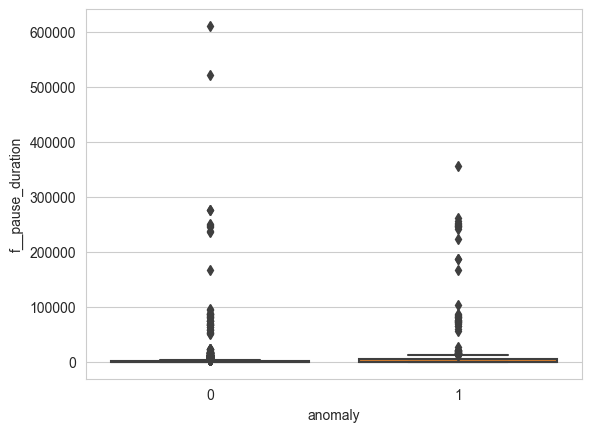

In [72]:
sns.boxplot(df,y=feature_name, x='anomaly')
plt.show()

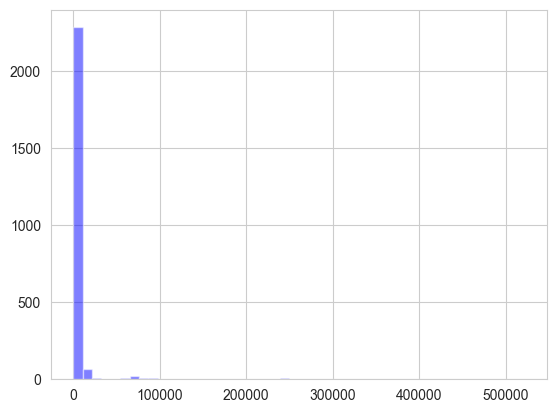

In [73]:
bins = np.histogram_bin_edges(df[df[feature_name]<df[df['anomaly']==0][feature_name].max()][feature_name], bins=48)
plt.hist(df[df[feature_name]<df[df['anomaly']==0][feature_name].max()][feature_name], bins=bins, alpha=0.5, color='blue', label='True')
plt.show()

In [74]:
df.groupby('survey_version').anomaly.value_counts()

survey_version  anomaly
EPforR_TAP_10   1            15
                0             3
EPforR_TAP_11   0           143
                1            78
EPforR_TAP_12   0          1366
                1           578
EPforR_TAP_13   0            31
                1            13
EPforR_TAP_14   0            35
                1            15
EPforR_TAP_15   0            22
                1            11
EPforR_TAP_16   0            26
                1            12
EPforR_TAP_17   0            35
                1            12
EPforR_TAP_18   0            14
                1            10
EPforR_TAP_19   1            12
                0             7
Name: anomaly, dtype: int64

In [75]:
df = df.groupby(['interview__id','survey_version'])['anomaly'].mean()
df = df.reset_index()

In [76]:
df['survey_label'] = df['survey_version'].apply(lambda x: False if int(x.split('_')[2])<13 else True)

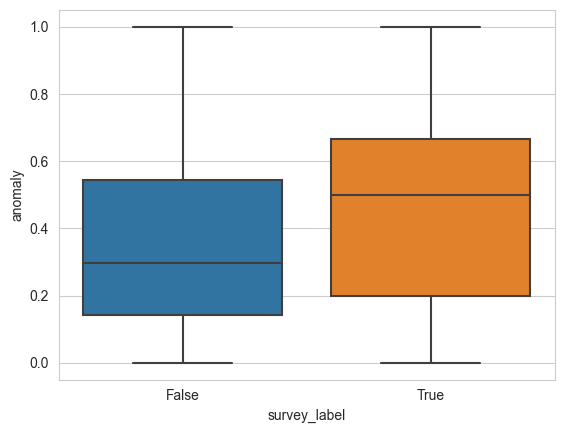

In [77]:
sns.boxplot(df,y='anomaly', x='survey_label')
plt.show()